In [1]:
import simpy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from itertools import product

from tqdm import tqdm_notebook

Simpy documentation - https://simpy.readthedocs.io/en/latest/contents.html 

## Useful functions

In [2]:
def add_client_to_matrix(matrix, priority, call_start_time):
    """
    Calling at client_generator
    """
    data = np.array([-1]*matrix.shape[1])
    id_ = len(matrix)
    data[cl_columns_map['id']] = id_
    data[cl_columns_map['priority']] = priority
    data[cl_columns_map['call_start_time']] = call_start_time
    mwt = np.random.triangular(12, np.mean([12,30]), 30) if priority==3 else np.random.triangular(8, np.mean([8,17]), 17)
    data[cl_columns_map['max_waiting_time']] = dt.timedelta(minutes=mwt).seconds
    data[cl_columns_map['status']] = map_cl_status_code['generated']
    data[cl_columns_map['call_type']] = np.random.choice(calls_type_distr.index, p=calls_type_distr['p'])
    return id_, np.append(matrix, [data], axis=0)

In [3]:
def set_op_mx(op_time_ds):
    op_mx = np.empty([0,len(op_columns)], dtype=np.int)
    for hour, row in op_time_ds.iterrows():
        for t,n in row.iteritems():
            for i in range(n):
                p = {'gold':1, 'silver':2, 'regular':3}[t]
                id_, op_mx = add_operator_to_matrix(op_mx, p, dt.timedelta(hours=int(hour)))
    return op_mx

In [4]:
def add_operator_to_matrix(matrix, priority, start_work_time, work_duration=dt.timedelta(hours=8).seconds):
    """
    Call manually when configuring operators shedule
    """
    data = np.array([-1]*matrix.shape[1])
    id_ = len(matrix)
    data[op_columns_map['id']] = id_
    data[op_columns_map['priority']] = priority
    data[op_columns_map['start_work_time']] = (start_work_time-dt.timedelta(hours=7)).seconds
    data[op_columns_map['work_duration']] = work_duration
    data[op_columns_map['efficiency']] = {1:12, 2:5, 3:0}[priority]
    return id_, np.append(matrix, [data], axis=0)

In [5]:
def get_client_ds(env):
    """
    Get pretty DataFrame with all the clients information
    """
    matrix = env.client_mx
    client_ds = pd.DataFrame(matrix, columns=cl_columns, dtype=np.int)
    client_ds = client_ds.replace(-1,np.nan)
    client_ds['status'] = client_ds['status'].transform(lambda x: map_code_cl_status[x])
    client_ds['type'] = client_ds['priority'].transform(lambda x: {1:'gold',2:'silver',3:'regular'}[x])
    client_ds['call_type'] = client_ds['call_type'].transform(lambda x: calls_type_distr.at[x, 'type'])
    client_ds = client_ds.drop('priority',axis=1)
    client_ds['max_waiting_time_dt'] = client_ds['max_waiting_time'].transform(lambda x: dt.timedelta(seconds=x))
    client_ds = client_ds.drop('max_waiting_time',axis=1)
    
    for i in ['call','block','queue','connect']:
        client_ds[f'{i}_duration_time'] = client_ds[f'{i}_end_time']-client_ds[f'{i}_start_time']
    
    for i in ['call', 'block', 'queue', 'connect']:
        for j in ['start','end','duration']:
            client_ds[f'{i}_{j}_time_dt'] = client_ds[f'{i}_{j}_time'].transform(
                lambda x: dt.timedelta(seconds=x) if x>=0 else None)
            if j!='duration':
                client_ds[f'{i}_{j}_time_dt'] = client_ds[f'{i}_{j}_time_dt']+dt.datetime(2018,1,1,7)
            client_ds = client_ds.drop(f'{i}_{j}_time', axis=1)
    
    client_ds['hour'] = [x.hour for x in client_ds['call_start_time_dt']]
    return client_ds

In [6]:
def get_operator_ds(env):
    matrix = env.op_mx
    operator_ds = pd.DataFrame(matrix, columns=op_columns, dtype=np.int)
    operator_ds = operator_ds.replace(-1, np.nan)
    operator_ds['type'] = operator_ds['priority'].transform(lambda x: {1:'gold',2:'silver',3:'regular'}[x])
    operator_ds['efficiency'] = operator_ds['efficiency']/100
    operator_ds['end_work_time'] = operator_ds['start_work_time']+operator_ds['work_duration']
    for i in ['start_work_time', 'end_work_time', 'work_duration']:
            operator_ds[f'{i}_dt'] = operator_ds[i].transform(
                lambda x: dt.timedelta(seconds=x) if x>=0 else None)
            if 'duration' not in i:
                operator_ds[f'{i}_dt'] = operator_ds[f'{i}_dt']+dt.timedelta(hours=7)#dt.datetime(2018,1,1,7)
    
    operator_ds = operator_ds.drop(['priority', 'start_work_time', 'work_duration', 'end_work_time'], axis=1)
    return operator_ds

In [7]:
def get_client_calls_distribution(client_ds):
    call_numbers = client_ds.groupby(['type', 'hour'])['id'].count().to_frame()
    call_numbers['type'] = [x[0] for x in call_numbers.index.values]
    call_numbers['hour'] = [x[1] for x in call_numbers.index.values]
    call_numbers.index = range(len(call_numbers))
    call_numbers = call_numbers.pivot_table(columns=['type'], index=['hour'], values='id')
    call_numbers = call_numbers.reindex(columns=['gold','silver','regular'])
    return call_numbers

In [8]:
def plot_client_calls_distribution(calls_distribution, figsize=(15,5), colors=['gold','silver','black']):
    plt.figure(figsize=figsize)
    for idx, f in enumerate(calls_distribution.columns):
        label = {0:'gold',1:'silver',2:'ordinary'}[idx]+' empirical'
        plt.plot(calls_distribution[f]/3600, '-', label=label, color=colors[idx])
    for idx, f in enumerate(call_frequency_ds.columns):
        label = {0:'gold',1:'silver',2:'ordinary'}[idx]+' theoretical'
        plt.plot(call_frequency_ds[f]/3600, '--', label=label, color=colors[idx])
    plt.legend()
    plt.title('Client calls distribution')
    plt.ylabel('probability')
    plt.xlabel('hour')
    plt.show()

In [9]:
def plot_call_types_distribution(client_ds, figsize=(8,4)):
    plt.figure(figsize=figsize)
    s = client_ds.groupby('call_type')['id'].count()/len(client_ds)
    s = s.reindex(calls_type_distr['type'])
    plt.bar(calls_type_distr.index-0.2, s, label='empirical', width=0.4)
    plt.bar(calls_type_distr.index+0.2, calls_type_distr['p'], label='theoretical', width=0.4)
    plt.title('Call types distribution')
    plt.xticks(calls_type_distr.index, calls_type_distr['type'])
    plt.ylim(0,1)
    plt.ylabel('probability')
    plt.legend()
    plt.show()

In [10]:
def plot_connection_duration_distr(client_ds, figsize=(15,15)):
    ds = client_ds[['call_type', 'connect_duration_time_dt', 'operator_id']].dropna()
    ds = pd.merge(ds, op_ds, left_on='operator_id', right_on='id'
                  ).drop(['id','operator_id'],axis=1).rename(columns={'type':'operator_type'})
    ds['connect_duration_time_dt'] = [x.seconds for x in ds['connect_duration_time_dt']]
    
    plt.figure(figsize=figsize)
    for op_type_id in range(3):
        for call_type_id in range(3):
            plt.subplot(3,3,op_type_id*3+call_type_id+1)
            call_type = calls_type_distr.at[call_type_id, 'type']
            op_type = {idx:t for idx,t in enumerate(['gold','silver','regular'])}[op_type_id]
            plt.title(call_type)
            plt.ylabel(op_type)
            cds = ds[(ds['call_type']==call_type)&(ds['operator_type']==op_type)]
            sns.distplot(cds['connect_duration_time_dt'],
                         label='empirical')
            stime, etime = calls_type_distr.loc[call_type_id, ['serv_time', 'extra_time']]
            #stime = np.array(stime)+etime[0] #if etime is normal
            stime = np.array(stime)+(etime[0]+etime[1])/2 #if etime is kind of triangular
            op_eff = cds['efficiency'].values[0]
            stime = stime*(1-op_eff)
            h = 2/(stime[2]-stime[0])
            plt.plot(stime, [0,h,0], label='theoretical')
            plt.ylim(0, h*1.2)
            plt.xlabel('connection duration (sec)')
            
            plt.text(cds['connect_duration_time_dt'].max()*0.85 ,h,'Calls amount: {}'.format(len(cds)))
    plt.figlegend()
    plt.suptitle('Connection duration distributions', size=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [11]:
def plot_clients_success(client_ds, figsize=(15,5)):
    cds = client_ds[['type']].rename(columns={'type':'client_type'})
    cds['success'] = client_ds['status'].isin(['drop_success','connected'])
    cds['hour'] = [x.hour if x else None for x in client_ds['call_start_time_dt']]
    cds = cds.pivot_table(index='client_type', columns='hour', values='success', aggfunc='mean').reindex(['gold','silver','regular'])
    plt.figure(figsize=figsize)
    sns.heatmap(cds, vmin=0, vmax=1, cmap='Greens', square=True, annot=True, fmt='.2%')
    plt.title('Successed clients')
    plt.show()

In [12]:
def plot_clients_no_lines(client_ds, figsize=(15,5)):
    cds = client_ds[['type']].rename(columns={'type':'client_type'})
    cds['client_type'] = cds['client_type'].transform(lambda x:'vip' if x != 'regular' else x)
    cds['no_lines'] = client_ds['status']=='no_lines'
    cds['hour'] = [x.hour if x else None for x in client_ds['call_start_time_dt']]
    
    plt.figure(figsize=figsize)
    grid = plt.GridSpec(1, 4, wspace=0.4, hspace=0.3,)
    plt.subplot(grid[:3])
    sns.heatmap(cds.pivot_table(index='client_type', columns='hour', values='no_lines', aggfunc='mean').reindex(['vip','regular']),
                vmin=0, vmax=1, cmap='Greens_r', square=True, center=0.02, annot=True, fmt='.2%', cbar=False)
    plt.subplot(grid[3])
    sns.heatmap(cds.groupby('client_type')['no_lines'].mean().to_frame().reindex(['vip','regular']),
                vmin=0, vmax=1, cmap='Greens_r', square=True, center=0.02, annot=True, fmt='.2%')
    plt.suptitle('Clients got no_lines')
    plt.show()

In [13]:
def plot_clients_waitings(client_ds, figsize=(15,5)):
    cds = client_ds[['type', 'call_start_time_dt', 'queue_duration_time_dt']].rename(columns={'type':'client_type'}).dropna()
    cds['hour'] = [x.hour if x else None for x in cds['call_start_time_dt']]
    cds['duration'] = [x.seconds for x in cds['queue_duration_time_dt']]
    cds['limit_time_wait'] = cds['client_type'].transform(lambda x: {'gold':90, 'silver':180, 'regular':900}[x])
    cds['less_then_limit'] = cds['duration']<cds['limit_time_wait']
    
    plt.figure(figsize=figsize)
    grid = plt.GridSpec(1, 4, wspace=0.4, hspace=0.3,)
    plt.subplot(grid[:3])
    sns.heatmap(cds.pivot_table(index='client_type', columns='hour', values='less_then_limit', aggfunc='mean').reindex(['gold','silver','regular']),
                vmin=0, vmax=1, cmap='Greens', square=True, annot=True, fmt='.2%', cbar=False)
    plt.subplot(grid[3])
    sns.heatmap(cds.groupby('client_type')['less_then_limit'].mean().to_frame().reindex(['gold','silver','regular']),
                vmin=0, vmax=1, cmap='Greens', square=True, annot=True, fmt='.2%')

    plt.suptitle('Clients waiting less then limit')
    plt.show()

In [14]:
def get_simulation_stat(client_ds, op_ds):
    gold_queue_waiting = (client_ds[client_ds['type']=='gold']['queue_duration_time_dt'].dropna()<dt.timedelta(seconds=90)).mean()
    silver_queue_waiting = (client_ds[client_ds['type']=='silver']['queue_duration_time_dt'].dropna()<dt.timedelta(minutes=3)).mean()
    regular_queue_waiting = (client_ds[client_ds['type']=='regular']['queue_duration_time_dt'].dropna()<dt.timedelta(minutes=15)).mean()

    vip_no_lines = (client_ds[client_ds['type'].isin(['gold','silver'])]['status']=='no_lines').mean()
    regular_no_lines = (client_ds[client_ds['type']=='regular']['status']=='no_lines').mean()
    
    op_ds['salary'] = op_ds['type'].transform(lambda x: {'regular': 400, 'silver':500, 'gold':600}[x])
    op_ds['salary'] = op_ds['salary']*[x.seconds//3600 for x in op_ds['work_duration_dt']]
    
    cost = op_ds['salary'].sum() + max(n_lines-50,0)*2000
    
    sim_data = {
        'n_lines':n_lines, 'n_vip_lines': n_vip_lines, 'cost':cost,
        'vip_no_lines': vip_no_lines, 'regular_no_lines': regular_no_lines,
        'gold_wait': gold_queue_waiting, 'silver_wait': silver_queue_waiting, 'regular_wait': regular_queue_waiting
    }
    sim_data = dict(sim_data,
        **{k:v for v,k in zip(op_time_ds.values.flatten(), [f'{t}_{h}' for h,t in product(op_time_ds.index, op_time_ds.columns,)])},
        )
    return sim_data

# Data preparation

In [15]:
cl_statuses = ['generated', 'ask_for_line', 'get_line', 'no_lines', 'blocked',
               'unblocked', 'drop_on_unblock', 'in_queue', 'drop_from_queue', 'connected',
               'drop_success']
map_cl_status_code = {s:idx for idx,s in enumerate(cl_statuses)}
map_code_cl_status = {v:k for k,v in map_cl_status_code.items()}

In [16]:
cl_columns = ['id','priority','call_start_time','call_end_time','max_waiting_time','status', 'call_type',
             'block_start_time', 'block_end_time',
             'queue_start_time', 'queue_end_time',
             'connect_start_time', 'connect_end_time', 'operator_id']
cl_columns_map = {k:idx for idx,k in enumerate(cl_columns)}

In [17]:
op_columns = ['id', 'priority', 'efficiency', 'start_work_time', 'work_duration']
op_columns_map = {k:idx for idx,k in enumerate(op_columns)}

In [18]:
call_frequency_ds = pd.DataFrame()
call_frequency_ds['time_range'] = range(7,19)
call_frequency_ds['regular_clients'] = [87, 165, 236, 323, 277, 440, 269, 342, 175, 273, 115,  56]
call_frequency_ds['vip_clients'] = [89, 243, 221, 180, 301, 490, 394, 347, 240, 269, 145,  69]
call_frequency_ds['silver_clients'] = 0.68*call_frequency_ds['vip_clients']
call_frequency_ds['gold_clients'] = call_frequency_ds['vip_clients']-call_frequency_ds['silver_clients']
call_frequency_ds.index = call_frequency_ds['time_range']
call_frequency_ds = call_frequency_ds.reindex(columns=['gold_clients', 'silver_clients', 'regular_clients'])
call_frequency_ds

,gold_clients,silver_clients,regular_clients
time_range,,,
7,28.48,60.52,87
8,77.76,165.24,165
9,70.72,150.28,236
10,57.60,122.40,323
11,96.32,204.68,277
12,156.80,333.20,440
13,126.08,267.92,269
14,111.04,235.96,342
15,76.80,163.20,175


In [19]:
calls_type_distr = pd.DataFrame([['info', 'Информация', 0.16, (1.2, 2.05, 3.75), (0.05, 0.1)],
                                 ['book', 'Бронь', 0.76, (2.25, 2.95, 8.6), (0.5, 0.8)],
                                 ['rebook', 'Перебронь', 0.08, (1.2, 1.9, 5.8), (0.4, 0.6)]],
                                columns=['type', 'type_rus', 'p', 'serv_time', 'extra_time'])
calls_type_distr['serv_time'] = [[dt.timedelta(minutes=y).seconds for y in x] for x in calls_type_distr['serv_time']]
calls_type_distr['extra_time'] = [[dt.timedelta(minutes=y).seconds for y in x] for x in calls_type_distr['extra_time']]
calls_type_distr

,type,type_rus,p,serv_time,extra_time
0,info,Информация,0.16,"[72, 123, 225]","[3, 6]"
1,book,Бронь,0.76,"[135, 177, 516]","[30, 48]"
2,rebook,Перебронь,0.08,"[72, 114, 348]","[24, 36]"


In [20]:
try:
    simulation_ds = pd.read_csv('simulation_ds.csv', index_col=0)
except:
    simulation_ds = pd.DataFrame(columns=[
    'n_lines', 'n_vip_lines', 'cost',
    'gold_wait', 'silver_wait', 'regular_wait',
    'vip_no_lines', 'regular_no_lines',
    'gold_7', 'gold_8', 'gold_9', 'gold_10', 'gold_11',
    'silver_7', 'silver_8', 'silver_9', 'silver_10', 'silver_11',
    'regular_7', 'regular_8', 'regular_9', 'regular_10', 'regular_11',
    ])

# Set model

In [21]:
class Queue(sp.PriorityStore):
    """
    Queue where clients are waiting till operators catch them.
    Combination of simpy PriorityStore and FilterStore.
    When calling get(filter) it return item (client) with least priority (the most important) who matches filter
    """
    get = sp.core.BoundClass(sp.resources.store.FilterStoreGet)
    """Request a to get an *item*, for which *filter* returns ``True``, out of
    the store."""

    def _do_get(self, event):
        for item in self.items:
            if event.filter(item):
                self.items.remove(item)
                event.succeed(item)
                break
        return True

In [22]:
class CallCenter(object):
    def __init__(self, env, n_lines, n_vip_lines):
        self.env = env
        self.n_lines = n_lines
        self.n_vip_lines = n_vip_lines
        self.lines = sp.Resource(env, capacity=self.n_lines)
        self.queue = Queue(env)

    def request_line(self, client):
        """
        Execute when client starts calling
        """
        cl_id = client.id_
        cl_priority =  client.get_mx_field('priority')
        n_lines_to_give = self.n_lines-self.n_vip_lines if cl_priority==3 else self.n_lines
        if self.lines.count<n_lines_to_give:
            req = self.lines.request()
            req.cl_id = cl_id
            client.req = req
            yield req
            client.set_status('get_line')
        else:
            raise self.NoLinesAvailable()
        yield self.env.process(self.put_to_queue(client))
    
    def release_line(self, client):
        """
        Execute when client dropped the phone
        """
        if client.id_ in [i.item.id_ for i in self.queue.items]:
            yield self.queue.get(lambda x: x.item.id_==client.id_)
        yield self.lines.release(client.req)
    
    def put_to_queue(self, client):
        cl_id = client.id_
        cl_priority = client.get_mx_field('priority')
        if cl_priority == 3:
            yield self.queue.put(sp.PriorityItem(cl_priority, client))
            client.put_in_queue.succeed()
            yield self.env.timeout(1)
            # If client is still in queue, estimate its waiting time
            if client in [x.item for x in self.queue.items]:
                yield self.queue.get(lambda x: x.item.id_==client.id_)
                client.waiting_queue.interrupt()
                self.env.process(self.block_client(client))
        else:
            self.env.process(self.block_client(client))
            
    def request_client(self, operator):
        """
        Execute when operator is freed and ready to take another client
        """
        op_id = operator.id_
        op_priority = operator.get_mx_field('priority')
        client = yield self.queue.get(lambda cl: cl.priority<=op_priority)
        client = client.item
        return client
    
    def block_client(self, client):
        """
        Execute when client should be blocked.
        For regular clients: "blocking" is when system "estimates" time for client to wait in queue
        For vip clients: "blocking" is "entering" vip card ids
        """
        client.block.succeed()
        cl_priority = client.get_mx_field('priority')
        if cl_priority == 3:
            block_time = 7
        else:
            block_time = int(round(np.random.uniform(7,16),0))
        yield self.env.timeout(block_time)
        ttw = self.estimate_wait_time(client)
        dropped = yield self.env.process(client.decide_to_drop_unblock(time_to_wait=ttw))
        if not dropped:
            yield self.queue.put(sp.PriorityItem(cl_priority, client))
            client.put_in_queue.succeed()
    
    def estimate_wait_time(self, client):
        """
        Function to estimate how much time client will wait in queue
        """
        return 0  # For testing purposes only
    
    class NoLinesAvailable(sp.exceptions.SimPyException):
        """
        Special exception saying there no free phone lines that client cat occupy
        """
        pass

In [23]:
class Client(object):
    def __init__(self, env, id_):
        self.env = env
        self.id_ = id_
        
        self.put_in_queue, self.get_from_queue = env.event(), env.event()
        self.block, self.unblock = env.event(), env.event()
        self.connect, self.disconnect = env.event(), env.event()
                
        self.waiting_block = env.process(self.wait_in_block())
        self.waiting_queue = env.process(self.wait_in_queue())
        self.talking_proc = env.process(self.talk_with_operator())
        self.action = env.process(self.call())
    
    def call(self):
        """
        When client is just generated and calling to system
        """
        cc = self.env.call_center
        try:
            self.set_status('ask_for_line')
            yield self.env.process(cc.request_line(self))
        except cc.NoLinesAvailable as e:
            self.set_status('no_lines')
            return
    
    def drop_call(self, status):
        """
        When client wants to drop the phone by some reason given in 'status'
        """
        yield self.env.process(self.env.call_center.release_line(self))
        self.set_mx_field('call_end_time', self.env.now)
        self.set_status(status)
    
    def wait_in_queue(self):
        """
        When client waiting in queue till he/she decide to drop the phone
        """
        while True:
            yield self.put_in_queue
            self.set_status('in_queue')
            self.set_mx_field('queue_start_time', self.env.now)
            try:
                prio = self.get_mx_field('priority')
                mqwt = {1:3, 2:6, 3:30}[prio]
                mqwt = dt.timedelta(minutes=mqwt).seconds #CHANGE TO WHAT? TASK VALUES ARE FOR OTHER MEASURES
                yield self.env.timeout(mqwt)
                yield self.env.process(self.drop_call('drop_from_queue'))
            except sp.Interrupt: 
                pass
            self.set_mx_field('queue_end_time', self.env.now)
            self.put_in_queue = self.env.event()
        
    def wait_in_block(self):
        """
        When client is blocked and "do" something mentioned in CallCenter.block_client()
        """
        yield self.block
        self.set_status('blocked')
        self.set_mx_field('block_start_time', self.env.now)
        
    def decide_to_drop_unblock(self, time_to_wait):
        """
        When client is told how much time he/she will wait in queue
        """
        mwt = self.get_mx_field('max_waiting_time')
        self.set_mx_field('block_end_time', self.env.now)
        if time_to_wait > mwt:
            yield self.env.process(self.drop_call('drop_on_unblock'))
            return True
        return False
        
    def talk_with_operator(self):
        """
        When client is connected with operator and "talks" with him/her
        """
        yield self.connect
        self.waiting_queue.interrupt()
        self.set_status('connected')
        self.set_mx_field('connect_start_time', self.env.now)
        yield self.disconnect
        self.set_mx_field('connect_end_time', self.env.now)
        yield self.env.process(self.drop_call('drop_success'))
    
    def set_mx_field(self, field, value):
        """
        Function for code to be more readable
        """
        self.env.client_mx[self.id_, cl_columns_map[field]] = value 
    
    def set_status(self, status):
        """
        Function for code to be more readable
        """
        self.set_mx_field('status', map_cl_status_code[status])
        
    def set_call_end_time(self):
        """
        Function for code to be more readable
        """
        self.set_mx_field('call_end_time', self.env.now)
    
    def get_mx_field(self, field):
        """
        Function for code to be more readable
        """
        return self.env.client_mx[self.id_, cl_columns_map[field]]

In [24]:
class Operator(object):
    def __init__(self, env, id_):
        self.env = env
        self.id_ = id_
        
        self.action = env.process(self.start_working())
        
    def start_working(self):
        swt = self.get_mx_field('start_work_time')
        yield self.env.timeout(swt)
        yield self.env.process(self.working())
        
    def working(self):
        swt, wd = [self.get_mx_field(f) for f in ['start_work_time', 'work_duration']]
        while self.env.now<swt+wd:         
            client = yield self.env.process(self.env.call_center.request_client(self))
            client.set_mx_field('operator_id', self.id_)
            client.connect.succeed()
            call_t = client.get_mx_field('call_type')
            serv_t, extr_t = calls_type_distr.loc[call_t, ['serv_time','extra_time']]
            serv_t = np.random.triangular(*serv_t)
            #extr_t = max(np.random.normal(*extr_t), 0) #dist should be normal but values are strange
            extr_t = np.random.triangular(extr_t[0], (extr_t[0]+extr_t[1])/2, extr_t[1])
            total_t = serv_t+extr_t
            efficiency = self.get_mx_field('efficiency')
            total_t = int(round(total_t*(1-efficiency/100),0))
            yield self.env.timeout(total_t)
            client.disconnect.succeed()
            
    def get_mx_field(self, field):
        """
        Function for code to be more readable
        """
        return self.env.op_mx[self.id_, op_columns_map[field]]

In [25]:
def client_generator(env):
    while True:
        for cl_priority in range(1,4):
            p = call_frequency_ds.iat[env.now//3600, cl_priority-1]/3600
            if np.random.rand()<p:
                id_, env.client_mx = add_client_to_matrix(env.client_mx, cl_priority, env.now)
                client = Client(env, id_)
        yield env.timeout(1)

In [26]:
def init_env():
    env = sp.Environment()
    env.client_mx = np.empty([0,len(cl_columns)], dtype=np.int) #matrix to write clients data
    env.op_mx = set_op_mx(op_time_ds) #matrix with operators data
    env.call_center = CallCenter(env, n_lines=n_lines, n_vip_lines=n_vip_lines) 
    env.client_generator = env.process(client_generator(env))
    env.operators = [Operator(env, id_) for id_ in env.op_mx[:,op_columns_map['id']]]
    return env

# Set simulation and run

In [27]:
n_lines = 55
n_vip_lines = 3

In [28]:
op_time_ds = pd.DataFrame(index=range(7,12))
op_time_ds['gold'] = [3, 4, 0, 0, 3]
op_time_ds['silver'] = [5, 6, 0, 5, 4]
op_time_ds['regular'] = [6, 10, 10, 7,6]
op_time_ds

,gold,silver,regular
7,3,5,6
8,4,6,10
9,0,0,10
10,0,5,7
11,3,4,6


In [29]:
env = init_env()
for i in tqdm_notebook(range(dt.timedelta(hours=12, minutes=0, seconds=0).seconds)):
    env.run(until=i+1)

A Jupyter Widget

In [30]:
client_ds = get_client_ds(env)
op_ds = get_operator_ds(env)

sim_data = get_simulation_stat(client_ds, op_ds)
simulation_ds = simulation_ds.append(sim_data, ignore_index=True)

simulation_ds.to_csv('simulation_ds.csv')

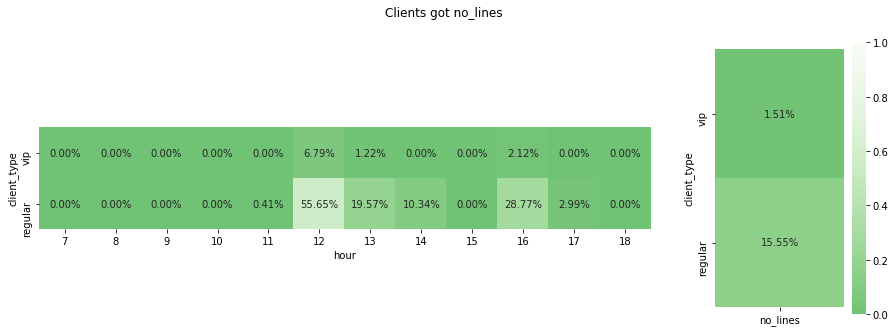

In [31]:
plot_clients_no_lines(client_ds)

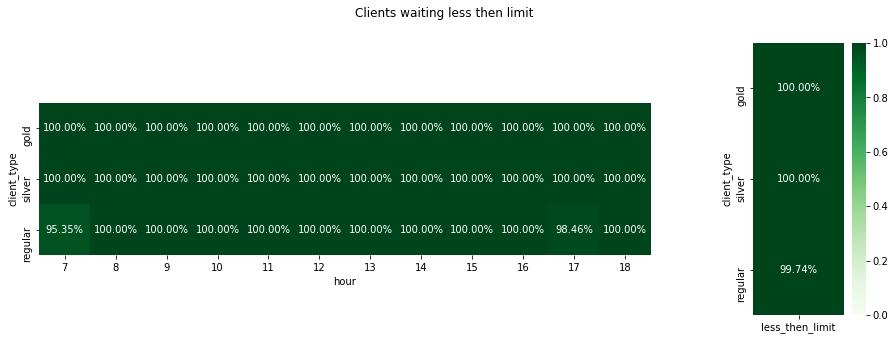

In [32]:
plot_clients_waitings(client_ds)

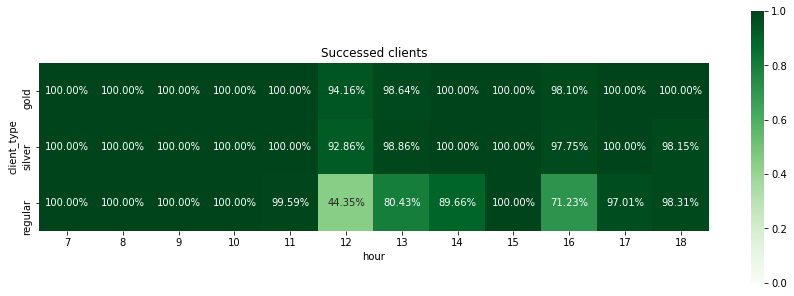

In [33]:
plot_clients_success(client_ds)

# Find best parameters

In [34]:
cds = simulation_ds.copy()

In [35]:
cds = cds[(cds['gold_wait']>=0.98)&(cds['silver_wait']>=0.95)&(cds['regular_wait']>=0.85)
   &(cds['regular_no_lines']<=0.2)&(cds['vip_no_lines']<=0.02)]

In [36]:
cds.shape

(34, 23)

In [37]:
cds.sort_values('cost').iloc[0]

n_lines                 55.000000
n_vip_lines              5.000000
cost                242000.000000
gold_wait                1.000000
silver_wait              0.999496
regular_wait             0.970962
vip_no_lines             0.002691
regular_no_lines         0.192938
gold_7                   5.000000
gold_8                   0.000000
gold_9                   0.000000
gold_10                  0.000000
gold_11                  5.000000
silver_7                 8.000000
silver_8                 0.000000
silver_9                 0.000000
silver_10                0.000000
silver_11               10.000000
regular_7                6.000000
regular_8               10.000000
regular_9                9.000000
regular_10               5.000000
regular_11               5.000000
Name: 60, dtype: float64